## In this catalog, we will use the HALO cosmoDC2 catalog with True richness computed by wazp as the some of the member probabilities that passes the zstar+2 cut

In [1]:
###################################################

# Standard library
import time
from functools import partial

# Core scientific stack
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# Astronomy / cosmology
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo

# Cosmology / large-scale structure
import pyccl as ccl

# Catalog / data access
from crow import mass_proxy

# Arrow / parquet
import pyarrow as pa
import pyarrow.parquet as pq

# MCMC
import emcee


In [2]:
# Read the FITS file into a table
catalog = Table.read("/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

# ----------------------------
# Murata model
# ----------------------------
m_pivot = 14.3
z_pivot = 0.5

mass_richness = mass_proxy.MurataUnbinned(m_pivot, z_pivot)

rng = np.random.default_rng()
display(catalog)
# ----------------------------
# Output parquet writer
# ----------------------------
output_file = "./cosmodc2_with_richness.parquet"
    
redshift = catalog["redshift_true"]
halo_mass = catalog["m200c"]
log10_mass = np.log10(halo_mass)
true_richness = catalog['richness_z_star2']


df = pd.DataFrame(
    {
        "redshift": np.array(redshift, dtype=float),
        "halo_mass": np.array(halo_mass, dtype=float),
        "log10_halo_mass": np.array(log10_mass, dtype=float),
        "richness": np.array(true_richness, dtype=float),
    }
)

table = pa.Table.from_pandas(df, preserve_index=False)

writer = pq.ParquetWriter(output_file, table.schema)

writer.write_table(table)

writer.close()
display(df)
print(f"Saved richness catalog to {output_file}")
print(np.log10(np.min(catalog[catalog['richness_z_star2'] >20]["m200c"])))

halo_id,ra_true,dec_true,ra,dec,redshift_true,mass_fof,m200c,r200c,skysim_halo_id,NMEM,richness,NMEM_g_star2,NMEM_r_star2,NMEM_i_star2,NMEM_z_star2,NMEM_y_star2,richness_g_star2,richness_r_star2,richness_i_star2,richness_z_star2,richness_y_star2,ra_bary,dec_bary
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
1600020475,50.77596621112012,-27.11267297840223,50.775875822529436,-27.112584328955446,0.04530489444732666,2.247e+13,18901145086557.746,0.5539122181878964,4308786475,14,8.259415690053675,4,2,2,2,2,3.3159297517335684,2.0,2.0,2.0,2.0,50.86080257640612,-27.111068884566034
2700020475,49.46685631106464,-25.960657456295777,49.466814189348334,-25.960541211222015,0.04615640640258789,1.633e+13,15062094204754.93,0.5136732064502341,5608786475,14,7.310438276043445,7,5,5,5,5,3.9505018568471444,3.162710828265532,3.162710828265532,3.162710828265532,3.162710828265532,49.430749682006216,-26.004253136511434
17200020453,50.16400668612118,-25.25905307744378,50.16585579512233,-25.259404686564693,0.08653247356414795,2.283e+13,20441971397588.734,0.5883426733419929,9508786453,12,5.623277102797734,5,5,5,4,4,3.3387389360236903,3.3387389360236903,3.3387389360236903,3.130245439035445,3.130245439035445,50.10887874151731,-25.222612608640762
19000020453,49.51595503782168,-26.130631687629403,49.51865674267036,-26.131426039026245,0.09413313865661621,1.199e+13,10668658238016.902,0.47378993370163613,29908786453,15,6.997234500189672,7,7,7,7,7,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,49.526283728873516,-26.143323644925193
19800020453,50.68971804154461,-26.886508987581664,50.691634217578326,-26.88681304144144,0.08739697933197021,8.412e+13,71624983358738.03,0.8935768839339135,10408786453,25,10.377440167337566,12,11,9,8,8,5.102184303491505,4.807846043434688,4.353673518160678,4.0503547588246684,4.0503547588246684,50.71067924047927,-26.883765517046655
32800020453,51.49229315287324,-26.308837160731073,51.49405530538187,-26.309071814426567,0.08795535564422607,1.328e+13,10371945197971.832,0.4693405728944591,14908786453,7,4.078294904689155,2,2,2,2,2,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,51.53207787114288,-26.281769096943737
2000020442,51.02799219278836,-25.768148487504888,51.03054382968504,-25.767733992572435,0.10751283168792725,3.555e+13,31256384653340.848,0.6889763852240335,9408786442,22,9.068648511775608,3,3,3,3,2,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.5330209172234177,51.04052597864433,-25.76994686512187
32300020442,51.47772552281113,-25.82579874206229,51.48013416475692,-25.825311694587846,0.10751473903656006,1.339e+13,11587427913554.93,0.49502278717470843,43208786442,10,5.4538674639470575,5,4,4,3,3,3.6826146155436636,2.6826146155436636,2.6826146155436636,2.0956992167416817,2.0956992167416817,51.46172414586285,-25.805957090122217
33300020442,50.31241043560731,-26.69591460405023,50.315518939516316,-26.69559169836869,0.108817458152771,3.434e+13,29876928281239.438,0.6786574780101507,44708786442,16,6.788349932828027,8,8,8,8,8,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,50.28802465790821,-26.712593565283026


,redshift,halo_mass,log10_halo_mass,richness
0,0.045305,1.890115e+13,13.276488,2.000000
1,0.046156,1.506209e+13,13.177885,3.162711
2,0.086532,2.044197e+13,13.310523,3.130245
3,0.094133,1.066866e+13,13.028110,3.975939
4,0.087397,7.162498e+13,13.855065,4.050355
...,...,...,...,...
454470,3.027283,1.039016e+13,13.016622,16.945251
454471,3.031686,1.009866e+13,13.004264,13.000000
454472,3.014547,1.138702e+13,13.056410,19.511205
454473,2.950915,1.233962e+13,13.091302,13.944438


Saved richness catalog to ./cosmodc2_with_richness.parquet
13.000102281133982


## We make a cut of M_200c = 4e13 to fit the mass-richness relation

In [5]:
t_halo = pd.read_parquet("./cosmodc2_with_richness.parquet")
t_halo=t_halo[t_halo['log10_halo_mass'] >= np.log10(4e13)]
t_cluster = pd.read_parquet("./cosmodc2_with_richness.parquet")
Mp, zp = 10**14.3, 0.5
cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)


## Mass-Richness

In [6]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, D, E = params
        if -2<E<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
def _ln_L(params, X, a, b, use_correction):
    # 1. Prior Check
    if not prior(params):
        return -np.inf
    
    # 2. Extract Data & Params
    pop, M, z = np.log(X["richness"]), X["halo_mass"], X["redshift"]
    
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, D, E = params
        mean_alpha = A + B*np.log(M/Mp)
        sigma = D + E*np.log(M/Mp)
    
    # 3. Physicality Check (Sigma must be positive for all points)
    if np.any(sigma <= 0):
        return -np.inf
    
    # 4. Standard Log-likelihood calculation
    # Using np.sum for speed and stability
    term1 = -0.5 * np.log(2 * np.pi * sigma**2)
    term2 = -0.5 * ((pop - mean_alpha) / sigma)**2
    ln_L = np.sum(term1 + term2)
    
    # 5. Optional Truncation Correction (Corrected logic)
    if use_correction:
        # P(a < NMEM < b) = 0.5 * [erf((log(b)-mu)/(sig*sqrt2)) - erf((log(a)-mu)/(sig*sqrt2))]
        inv_sig_root2 = 1.0 / (sigma * np.sqrt(2))
        def erf_func(val):
            return scipy.special.erf((np.log(val) - mean_alpha) * inv_sig_root2)
        
        prob_in_bin = 0.5 * (erf_func(b) - erf_func(a))
        # Add the log of the normalization to the total likelihood
        ln_L -= np.sum(np.log(np.clip(prob_in_bin, 1e-10, None)))
        
    return ln_L

def MCMC(richesse_bin, redshift_bin, itt, redshift_params=True, correction=True):
    a, b = richesse_bin
    c, d = redshift_bin
    
    # Selection
    mask = (t_halo["richness"] > a) & (t_halo["richness"] < b) & \
           (t_halo["redshift"] > c) & (t_halo["redshift"] < d)
            
    X = t_halo[mask]
    display(X)
    if len(X) < 10: # Safety check for empty bins
        print(f"Warning: Bin {richesse_bin}, {redshift_bin} has only {len(X)} clusters.")
        return {'mean': np.zeros(6 if redshift_params else 4), 'std': np.zeros(6 if redshift_params else 4)}

    ndim = 6 if redshift_params else 4
    nwalkers = 48 # Use a multiple of 2 or 4 for better threading
    
    # Better initialization
    if redshift_params:
        guess = np.array([3.2, 0.8, 0.1, 0.5, 0.01, 0.01])
    else:
        guess = np.array([3.2, 0.8, 0.5, 0.01])
        
    p0 = [guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    sampler.run_mcmc(p0, itt, progress=True)
    
    # Correct result extraction (Flattening)
    burn_in = int(itt * 0.3)
    unflat_samples = sampler.get_chain(discard=burn_in, flat=False)
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)    
    log_prob_unflat = sampler.get_log_prob(discard=burn_in, flat=False)
    log_prob_flat   = sampler.get_log_prob(discard=burn_in, flat=True)

    idx_best = np.argmax(log_prob_flat)
    theta_best = flat_samples[idx_best]
    
    return {
        'chains': unflat_samples,
        'log_prob': log_prob_unflat,
        'mean': np.mean(flat_samples, axis=0),
        'median': np.median(flat_samples, axis=0),
        'std': np.std(flat_samples, axis=0),
        'map': theta_best
    }

,redshift,halo_mass,log10_halo_mass,richness
378,0.561819,1.449053e+14,14.161084,21.077488
515,0.682978,1.228679e+14,14.089438,32.082183
540,0.693886,1.265716e+14,14.102336,26.138659
645,0.777342,2.062885e+14,14.314475,29.233499
657,0.765167,1.426826e+14,14.154371,30.702785
...,...,...,...,...
451590,0.651678,1.862916e+14,14.270193,21.537920
451991,0.810806,5.004717e+14,14.699380,56.831312
452057,0.803687,2.081807e+14,14.318440,22.723909
452082,0.794009,1.286121e+14,14.109282,24.403199


100%|██████████| 2000/2000 [01:34<00:00, 21.16it/s]


A: mean=2.9337, std=0.0535
A: median=2.9369, std=0.0535
B: mean=0.5910, std=0.0441
B: median=0.5899, std=0.0441
C: mean=1.2986, std=0.2400
C: median=1.2911, std=0.2400
D: mean=0.3644, std=0.0188
D: median=0.3640, std=0.0188
E: mean=0.0504, std=0.0128
E: median=0.0503, std=0.0128
F: mean=0.0221, std=0.0772
F: median=0.0234, std=0.0772


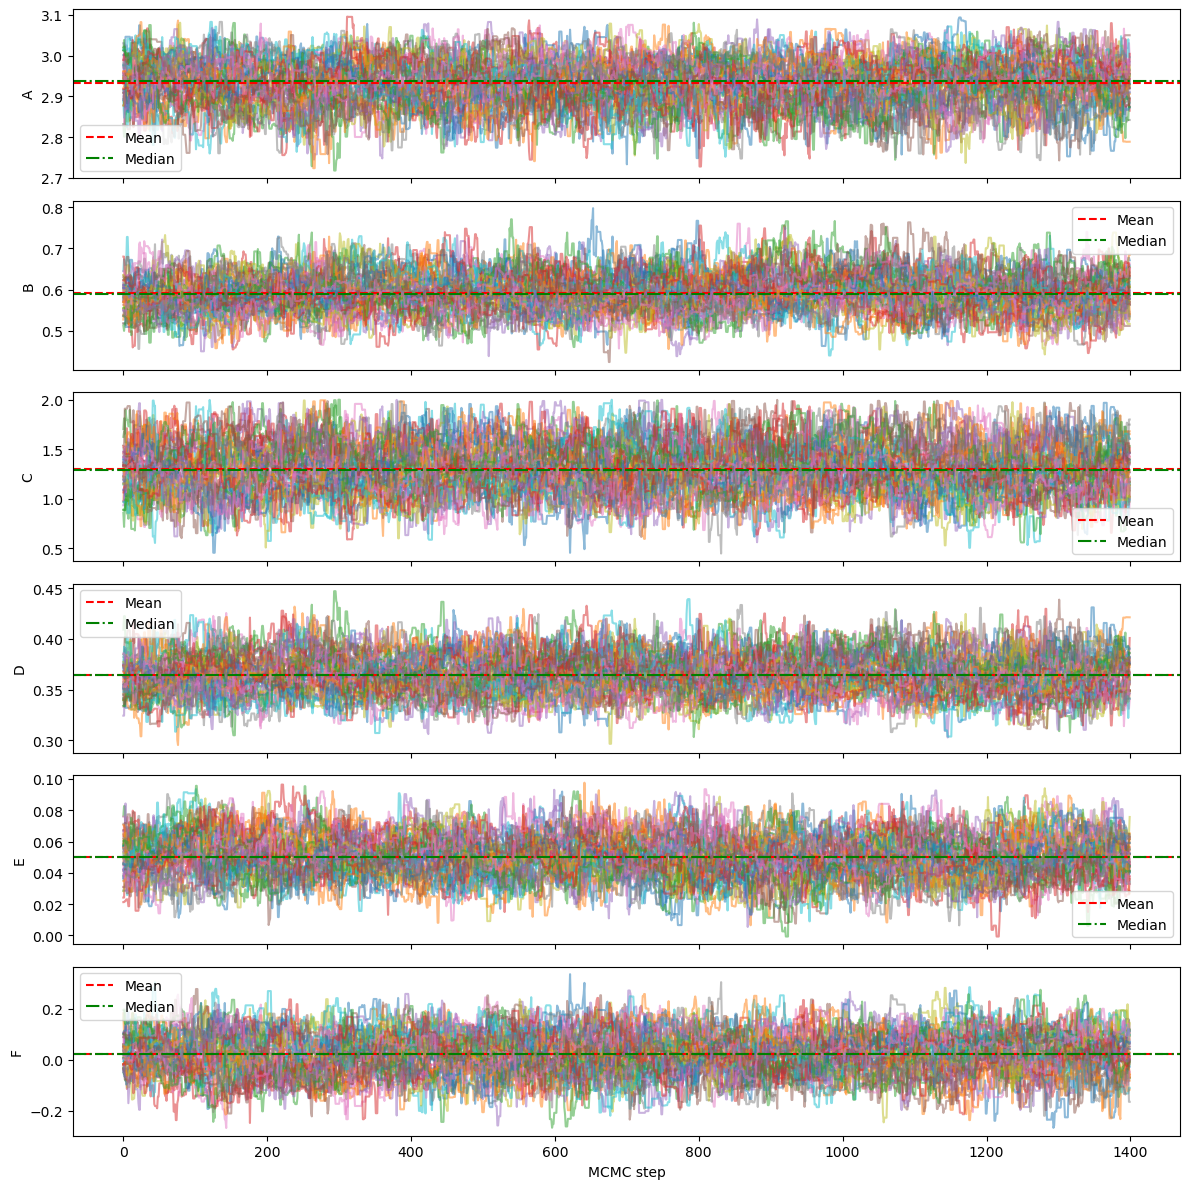

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------------------------
# Assuming you run MCMC once for all clusters (global), returns 6 parameters
# ------------------------------------------------------------------------------
best_fit_mor = []
# Run your MCMC once
res = MCMC(richesse_bin=(20,200), 
          redshift_bin=(0.2,1.0), 
          itt=2000, redshift_params=True, correction=True)
# Extract chains and statistics
chains = res['chains']  # shape: (nsteps, nwalkers, 6) or similar
means = res['mean']     # length 6
stds  = res['std']      # length 6
medians = res['median']
# Print best-fit values
param_names = ['A','B','C','D','E','F']
for i, name in enumerate(param_names):
    print(f"{name}: mean={means[i]:.4f}, std={stds[i]:.4f}")
    print(f"{name}: median={medians[i]:.4f}, std={stds[i]:.4f}")
    best_fit_mor.append(medians[i])
# ------------------------------------------------------------------------------
# Plot chains to check convergence
# ------------------------------------------------------------------------------
n_params = 6
nsteps, nwalkers = chains.shape[0], chains.shape[1]

fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i in range(n_params):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(chains[:, w, i], alpha=0.5)
    # Show mean and median lines
    mean_i = np.mean(chains[:, :, i])
    median_i = np.median(chains[:, :, i])
    ax.axhline(mean_i, color='red', linestyle='--', label='Mean')
    ax.axhline(median_i, color='green', linestyle='-.', label='Median')
    ax.set_ylabel(param_names[i])
    ax.legend()
axes[-1].set_xlabel('MCMC step')
plt.tight_layout()
plt.show()


## Plotting best fit results versus data

/tmp/ipykernel_212/179637617.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


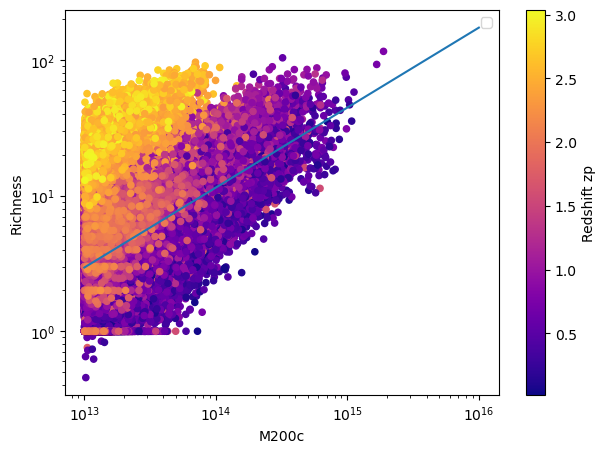

In [10]:
from crow import mass_proxy
best_fit = res["median"]
mass_richness_unb = mass_proxy.MurataUnbinned(np.log10(Mp), zp)

mass_richness_unb.parameters["mu0"] = best_fit[0]
mass_richness_unb.parameters["mu1"] = best_fit[1]
mass_richness_unb.parameters["mu2"] = best_fit[2]
mass_richness_unb.parameters["sigma0"] = best_fit[3]
mass_richness_unb.parameters["sigma1"] = best_fit[4]
mass_richness_unb.parameters["sigma2"] = best_fit[5]

plt.figure(figsize=(7,5))

sc = plt.scatter(
    t_cluster['halo_mass'],
    t_cluster['richness'],
    c=t_cluster['redshift'],
    cmap='plasma',
    s=20
)
# sc = plt.scatter(
#     t_cl_halo_match['m200c'],
#     t_cl_halo_match['n200'],
#     c=t_cl_halo_match['zp'],
#     cmap='viridis',
#     s=20
# )
rich_plot = np.linspace(np.log10(20),5, 200)
mass_plot = np.linspace(13, 16, 200)
mean = mass_richness_unb.get_ln_mass_proxy_mean(mass_plot, np.array([0.4]))

plt.colorbar(sc, label="Redshift zp")
plt.xlabel("M200c")
plt.ylabel("Richness")
plt.legend()
plt.plot(10**mass_plot, np.exp(mean))
plt.xscale('log')
plt.yscale('log')
plt.show()



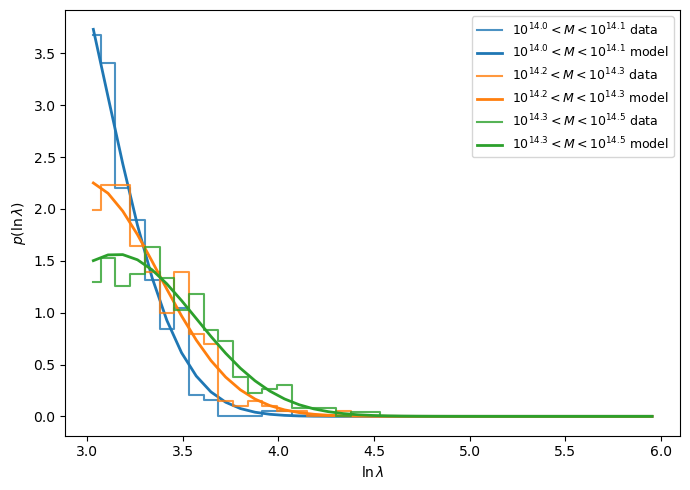

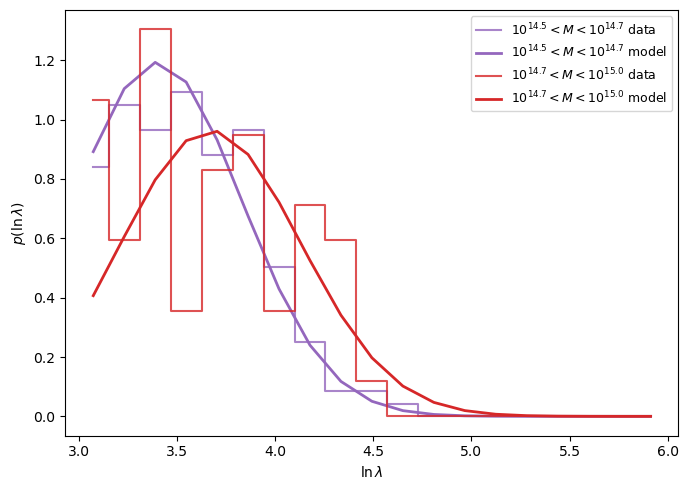

In [11]:
mass_bins_all = [
    (10**14.0, 10**14.1),
    (10**14.2, 10**14.3),
    (10**14.3, 10**14.5),
    (10**14.5, 10**14.7),
    (10**14.7, 10**15),
]
rich_cut = 20

colors_all = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:red"]

# --- First figure: first three bins ---
plt.figure(figsize=(7,5))
for (mmin, mmax), col in zip(mass_bins_all[:3], colors_all[:3]):

    mask = (
        (t_cluster['halo_mass'] > mmin) &
        (t_cluster['halo_mass'] < mmax) &
        (t_cluster['redshift'] > 0.3) &
        (t_cluster['redshift'] < 1.0)
    )

    rich_data = t_cluster['richness'][mask]
    z_data    = t_cluster['redshift'][mask]
    M_data    = t_cluster['halo_mass'][mask]

    bins = np.linspace(np.log(rich_cut), np.log(400), 40)
    hist, edges = np.histogram(np.log(rich_data), bins=bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])

    pdf = []
    for lnlam in centers:
        log10lam = lnlam / np.log(10)
        vals = mass_richness_unb.distribution(
                  np.array(np.log10(M_data)),
                  np.array(z_data),
                  np.full_like(M_data, log10lam)
               )
        pdf.append(np.mean(vals))
    pdf = np.array(pdf)

    label = fr"$10^{{{np.log10(mmin):.1f}}} < M < 10^{{{np.log10(mmax):.1f}}}$"
    plt.step(centers, hist/np.trapezoid(hist, centers), where='mid', color=col, alpha=0.8, label=label + " data")
    plt.plot(centers, pdf/np.trapezoid(pdf, centers), color=col, lw=2, label=label + " model")

plt.xlabel(r"$\ln \lambda$")
plt.ylabel(r"$p(\ln \lambda)$")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


# --- Second figure: last two bins ---
plt.figure(figsize=(7,5))
for (mmin, mmax), col in zip(mass_bins_all[3:], colors_all[3:]):

    mask = (
        (t_cluster['halo_mass'] > mmin) &
        (t_cluster['halo_mass'] < mmax) &
        (t_cluster['redshift'] > 0.3) &
        (t_cluster['redshift'] < 1.0)
    )

    rich_data = t_cluster['richness'][mask]
    z_data    = t_cluster['redshift'][mask]
    M_data    = t_cluster['halo_mass'][mask]

    bins = np.linspace(np.log(rich_cut), np.log(400), 20)
    hist, edges = np.histogram(np.log(rich_data), bins=bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])

    pdf = []
    for lnlam in centers:
        log10lam = lnlam / np.log(10)
        vals = mass_richness_unb.distribution(
                  np.array(np.log10(M_data)),
                  np.array(z_data),
                  np.full_like(M_data, log10lam)
               )
        pdf.append(np.mean(vals))
    pdf = np.array(pdf)

    label = fr"$10^{{{np.log10(mmin):.1f}}} < M < 10^{{{np.log10(mmax):.1f}}}$"
    plt.step(centers, hist/np.trapezoid(hist, centers), where='mid', color=col, alpha=0.8, label=label + " data")
    plt.plot(centers, pdf/np.trapezoid(pdf, centers), color=col, lw=2, label=label + " model")

plt.xlabel(r"$\ln \lambda$")
plt.ylabel(r"$p(\ln \lambda)$")
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


## Save to sacc

In [12]:
import math
import itertools

import numpy as np

from numcosmo_py import Nc
from numcosmo_py import Ncm

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import sacc

data_table = t_cluster
data_table = data_table[data_table['redshift'] >= 0.2]
data_table = data_table[data_table['redshift'] <= 1.0]
data_table = data_table[data_table['richness'] >= 20]
data_table = data_table[data_table['richness'] <= 200]


area = 439.78986

cluster_z = data_table["redshift"]
cluster_richness = np.log10(data_table["richness"])

bins_rich = np.log10([20,40, 60, 80])
bins_z = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, None, "count", bins=[bins_z, bins_rich]
)
print(cluster_counts)
print(np.sum(cluster_counts))
covariance = np.diag(cluster_counts.flatten())
print(np.mean(cluster_z), np.min(cluster_z))
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "cosmodc2_halos"
s_count.add_tracer("survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    lower, upper = richness_bin
    bin_richness_label = f"rich_{i}"
    s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
    bin_richness_labels.append(bin_richness_label)

#  pylint: disable-next=no-member
cluster_count = sacc.standard_types.cluster_counts

counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)


for counts_i, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_richness_label, bin_z_label), int(counts_i)
    )
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("./outputs_mor/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./outputs_cosmo/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./outputs_both/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./clusters_sacc_file.sacc", overwrite=True)


[[184.   9.   2.]
 [291.  28.   3.]
 [524.  43.   7.]
 [796.  66.  14.]]
1967.0
0.7234961366363866 0.20357179641723633
